In [233]:
#!pip install py2neo
import pandas as pd
import py2neo
import json
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
from py2neo import Graph, Node, Relationship
import numpy as np
import seaborn as sns
import random
import warnings

data_dir = 'C:/Users/werne/Documents/NSQL/data'

In [ ]:
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "rootuser"), name="mcu")
characters = pd.read_csv(data_dir+"characters.csv")

graph.delete_all()

try:
    graph.run("CREATE CONSTRAINT ON (n:Superhero) ASSERT n.id_ IS UNIQUE")
except:
    print("Constraint already exists")

transaction_list = []

for row in tqdm.tqdm(characters.iterrows()):
    id_ = row[1]["characterID"]
    name = row[1]["name"]
    transaction_list.append({"id_":id_,"name":name})
    # Commit when list = 1000, vary it depending of the case
    if len(transaction_list) == 1000:
        # UNWIND = split the list given to it (here $json because json=transaction_list)
        # For each dict do the following query CREATE (n:Superhero) SET n = data
        transaction = "UNWIND $json as data CREATE (n:Superhero) SET n = data"
        graph.run(transaction, json=transaction_list)
        transaction_list = []

graph.run(transaction, json=transaction_list)

pass

# Exercises

## CRUD operations:


#### 1 : You will continue to work on the MCU network for a while. Who are the 10 fastest in the MCU ? Are they related to each other ?

In [9]:
query = """
        MATCH (a:Superhero)
        WHERE a.Speed IS NOT NULL
        RETURN a.name AS Name
        ORDER BY a.Speed DESC
        LIMIT 10
        """

fast_list = graph.run(query).to_data_frame()
fastest_heroes = fast_list['Name'].tolist()
print(fast_list)

            Name
0     Black Bolt
1       Stardust
2    Quicksilver
3           Nova
4           Thor
5  Silver Surfer
6       Galactus
7       Dormammu
8            Ego
9      Northstar


In [10]:
query = """
        MATCH (a:Superhero)-[r]-(b:Superhero)
        WHERE a.name IN $names AND b.name IN $names AND a.name < b.name
        WITH a.name AS `Hero 1`, collect(b.name) AS `Related to`, size(collect(b.name)) AS `Connections`
        ORDER BY `Connections` DESC, `Hero 1`
        RETURN `Hero 1` AS Hero, `Related to`
        """

ordered_relations = graph.run(query, names=fastest_heroes).to_data_frame()

pd.set_option('display.max_colwidth', 100)
pd.set_option('display.width', 1000) 
print(ordered_relations)

            Hero                                                     Related to
0       Galactus  [Silver Surfer, Thor, Quicksilver, Nova, Northstar, Stardust]
1     Black Bolt             [Galactus, Silver Surfer, Thor, Quicksilver, Nova]
2            Ego             [Galactus, Silver Surfer, Thor, Quicksilver, Nova]
3       Dormammu                   [Galactus, Silver Surfer, Thor, Quicksilver]
4           Nova                             [Silver Surfer, Thor, Quicksilver]
5      Northstar                                            [Thor, Quicksilver]
6    Quicksilver                                          [Silver Surfer, Thor]
7  Silver Surfer                                               [Thor, Stardust]


#### 2 : How many have collaborated atleast more than 10 times with another superhero?

In [11]:
query = """
        MATCH (a:Superhero)-[r:RELATION]->(b:Superhero)
        WHERE r.n_collab > 10
        WITH a, b
        RETURN COUNT(DISTINCT a)
        """

collaborators_count = [i for i in graph.run(query)][0]#########################
print(collaborators_count, "superheroes have collaborated more than 10 times with another superhero")

449 superheroes have collaborated more than 10 times with another superhero


#### 3 : Did the weakest of the MCU collaborated with the strongest ?

In [14]:
query = """
        MATCH (weakest:Superhero), (strongest:Superhero)
        WHERE weakest.Total IS NOT NULL AND strongest.Total IS NOT NULL
        WITH weakest, strongest
        ORDER BY weakest.Strength ASC, strongest.Strength DESC
        LIMIT 1
        OPTIONAL MATCH (weakest)-[r:RELATION]->(strongest)
        RETURN strongest.name AS `Strongest Hero :`,
               weakest.name AS `Weakest Hero :`,
               r IS NOT NULL AS `Collaborated :`
        """

result = graph.run(query).to_data_frame()
result

,Strongest Hero :,Weakest Hero :,Collaborated :
0,Galactus,Lady Deathstrike,False


#### 4 : Give a stats that interests you ! 

In [429]:
characters = pd.read_csv(data_dir+"marvel_characters_info.csv")
print(f'{sum(characters["HairColor"]=="No Hair")*100/characters.shape[0]:.2f}% of Marvel characters are bald')

10.22% of Marvel characters are bald


#### 5 : Create a new db called "master". Create a graph from the M1 class with name and random age between 20 and 30, Group of 3 that collab (undirected relation).

In [16]:
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "rootuser"), name="master")

class_size = 18
names = ['YOU'] + [f'Person{i}' for i in range(1, class_size)]
random.shuffle(names)
age_list = [random.randint(20, 30) for _ in range(class_size)]
people_data = [{"name": name, "age": age} for name, age in zip(names, age_list)]

transaction = graph.begin()

nodes_to_create = {}
for person in people_data:
    person_node = py2neo.Node("Person", **person)
    transaction.create(person_node)
    nodes_to_create[person['name']] = person_node

for i in range(0, len(nodes_to_create) - 2, 3):
    persons = [nodes_to_create[names[i]], nodes_to_create[names[i+1]], nodes_to_create[names[i+2]]]
    for j in range(3):
        for k in range(j + 1, 3):
            transaction.create(py2neo.Relationship(persons[j], "COLLABORATES", persons[k]))
            transaction.create(py2neo.Relationship(persons[k], "COLLABORATES", persons[j]))

graph.commit(transaction)

#### 6 : Get the age for people YOU collaborate with.

In [17]:
query = """
        MATCH (you:Person {name: 'YOU'})-[:COLLABORATES]-(c:Person)
        RETURN DISTINCT c.name AS Name, c.age AS Age
        """

results = graph.run(query).to_data_frame()
results

,Name,Age
0,Person13,22
1,Person1,30


#### 7 : Get nodes with age > 25.

In [18]:
query = """
        MATCH (p:Person)
        WHERE p.age > 25
        RETURN p.name AS Name, p.age AS Age
        """

results = graph.run(query).to_data_frame()
results

,Name,Age
0,Person10,26
1,Person7,27
2,Person11,28
3,Person5,28
4,Person15,26
5,Person14,26
6,Person12,26
7,Person1,30
8,Person6,30
9,Person4,26


## Real world problem:

#### 8 : Using the downloaded data in TODO 11 of chapter II, create a collaboration network between authors for papers after 2021 (same author if same name). Insert it in neo4j in a db called "arxiv".

I couldn't find TODO 11 of chapter II.

#### 9 : Get the density of degrees of the collaboration network

#### 10 : Do a for loop for i in range(500) for each i remove nodes with a degree less than i.

## Real World application 3

You will work again on [pubmed_last_100k.json](https://we.tl/t-6afLCDGRsg). The goal in this homework is to insert collaboration data in Neo4j and then study it using cypher queries. The following questions are meant to guide you through the process.

In [458]:
graph = py2neo.Graph("bolt://localhost:7687", auth=("neo4j", "rootuser"), name="pubmed")

#### 1 : Each paper has a list of author and affiliations. The first step is to create a node per author with a list of affiliation as attribute. If a name appears multiple times consider it as a single person. Create an edge between two authors if they are on the same paper. You can use any kind of operation to clean the data before inserting, you decide which preprocessing step is the most convenient.

In [219]:
with open(data_dir+'pubmed_cleaned.json', 'r') as fp:
    papers = json.load(fp)

pprint(papers[:1], sort_dicts=False)

[{'_id': {'$oid': '60c715b4c4b7559e04fd9d24'},
  'pmid': 30006494,
  'title': 'Proton pump inhibitors and gastric cancer: association is not '
           'causation.',
  'ISSN': '1468-3288',
  'abstract': None,
  'meshwords': 'Anti-Ulcer Agents \n'
               'Helicobacter pylori \n'
               'Humans \n'
               'Proton Pump Inhibitors \n'
               'Stomach Neoplasms ',
  'meshsubwords': '',
  'authors': 'name ml Moayyedi P, affil str Division of Gastroenterology and '
             'Farncombe Family Digestive Health Research Institute, McMaster '
             'University, Hamilton, Ontario, Canada.\n'
             'name ml Veldhuyzen van Zanten SJO, affil str Division of '
             'Gastroenterology, University of Alberta, Edmonton, Alberta, '
             'Canada.\n'
             'name ml Hookey L, affil str Division of Gastroenterology, '
             "Queen\\'s University, Kingston, Ontario, Canada.\n"
             'name ml Armstrong D, affil str Division 

In [100]:
def organize_papers(papers):
    organized_papers = {}
    for paper in tqdm(papers, desc="Reorganizing information):
        paper_id = paper['_id']['$oid']
        organized_paper = {
            "team_size": paper.get("team_size", 0),
            "nb_country": paper.get("nb_country", 0),
            "country_list": paper.get("country_list", ""),
            "authors": {}
        }
        authors_info = paper.get("authors", "")
        authors_entries = authors_info.split('\n')

        for entry in authors_entries:
            if entry.strip():
                split_entry = entry.split(', affil str')
                if len(split_entry) < 2:
                    continue
                name_part = split_entry[0].strip()
                author_name = name_part.replace('name ml ', '').strip()
                affiliations_part = split_entry[1].strip()
                affiliations = [affil.strip() for affil in affiliations_part.split(';')]
                
                organized_paper["authors"][author_name] = {
                    "nb_affiliations": len(affiliations),
                    "affiliations": affiliations
                }
        organized_papers[paper_id] = organized_paper
    return organized_papers

def build_author_nodes(organized_papers):
    for paper_id, paper_details in tqdm(organized_papers.items(), desc="Creating Author Nodes"):
        authors = paper_details['authors']
        author_nodes = {}

        for author_name, details in authors.items():
            author_node = graph.nodes.match("Author", name=author_name).first()
            if not author_node:
                author_node = Node("Author", name=author_name, nb_affiliations=details["nb_affiliations"], affiliations=details["affiliations"])
                graph.create(author_node)
            author_nodes[author_name] = author_node

        author_names = list(authors.keys())
        for i in range(len(author_names)):
            for j in range(i + 1, len(author_names)):
                author1 = author_nodes[author_names[i]]
                author2 = author_nodes[author_names[j]]

                rel = graph.relationships.match((author1, author2), "COAUTHORED").first()
                if rel:
                    rel['collaborations'] = rel.get('collaborations', 1) + 1
                    graph.push(rel)
                else:
                    rel = Relationship(author1, "COAUTHORED", author2, collaborations=1)
                    graph.create(rel)
                    
                rel_reverse = graph.relationships.match((author2, author1), "COAUTHORED").first()
                if rel_reverse:
                    rel_reverse['collaborations'] = rel_reverse.get('collaborations', 1) + 1
                    graph.push(rel_reverse)
                else:
                    rel_reverse = Relationship(author2, "COAUTHORED", author1, collaborations=1)
                    graph.create(rel_reverse)

def create_paper_nodes(papers):
    for paper in tqdm(papers[:10_000], desc="Creating Paper Nodes"):
        properties = {
            'id': paper['_id']['$oid'], 
            'title': paper.get('title', 'No title provided'),
            'pmid': paper.get('pmid', None),
            'nb_country': paper.get('nb_country', None),
            'country_list': paper.get('country_list',None)
        }
        query = """
                MERGE (p:Paper {id: $id})
                ON CREATE SET p += $properties
                """
        graph.run(query, id=properties['id'], properties=properties)

In [4]:
organized_papers = organize_papers(papers[:10_000])
build_author_nodes(organized_papers)
create_paper_nodes(papers)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [40:46<00:00,  4.09it/s]


#### 2 : How many authors have more than 2 affiliations ?

In [97]:
query = """
        MATCH (a:Author)
        WHERE size(a.affiliations) > 2
        RETURN a.name AS AuthorName, a.affiliations AS Affiliations, size(a.affiliations) AS nb_affil
        """

results = graph.run(query).to_data_frame()
print(len(results), "authors have more than 2 affiliations")

1282 authors have more than 2 affiliations


#### 3 : Create a density of node degrees. Do you observe a power scale law ? What does it mean ?

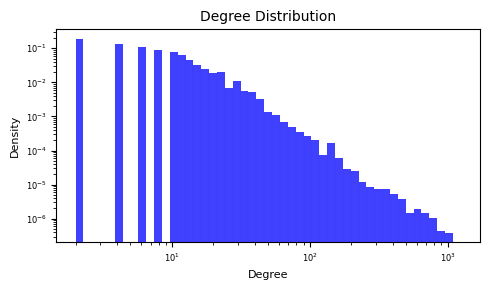

In [461]:
query = """
        MATCH (a:Author)-[:COAUTHORED]-()
        RETURN a.name AS Author, count(*) AS Degree
        ORDER BY Degree DESC
        """

results = graph.run(query).to_data_frame()

degrees = results['Degree'].tolist()
degrees = [x if np.isfinite(x) else np.nan for x in degrees]
degrees = [x for x in degrees if not pd.isna(x)]  # Remove NaN values that were originally inf


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    logbins = np.logspace(np.log10(min(degrees)), np.log10(max(degrees)), 50)
    plt.figure(figsize=(5, 3))
    sns.histplot(degrees, bins=logbins, kde=False, color="blue", stat="density")
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Degree Distribution', fontsize=10)
    plt.xlabel('Degree', fontsize=8)
    plt.ylabel('Density', fontsize=8)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()

The distribution seemingly follows a power law

#### 4 : Which country has seen the most international collaboration ?

In [102]:
query = """
        MATCH (p:Paper)
        WHERE p.nb_country > 1
        UNWIND split(p.country_list, ';') AS country
        WITH country, count(p) AS collaborations
        RETURN country, collaborations
        ORDER BY collaborations DESC
        LIMIT 1
        """

result = graph.run(query).data()[0]
pays = result['country']
collab = result['collaborations']

print(f"The country with the most international collaborations is {pays}, with a total of {collab} collaborations.")

The country with the most international collaborations is United States, with a total of 956 collaborations.


#### 5 : Who are the top 10 collaborators and what is their affiliation ?

In [103]:
query = """
        MATCH (a:Author)-[:COAUTHORED]-()
        WITH a, count(*) AS collaborations
        RETURN a.name AS Author, collaborations AS Collaborations, a.affiliations AS Affiliations
        ORDER BY collaborations DESC
        LIMIT 10
        """

results = graph.run(query).to_data_frame()
pd.set_option('display.max_colwidth', None)
results

,Author,Collaborations,Affiliations
0,Wang Y,1242,"[1Department of Critical Care Medicine, Second Affiliated Hospital, Zhejiang University School of Medicine, Hangzhou, Zhejiang 310009 People\'s Republic of China.]"
1,Zhang Y,1000,"[1Guangdong Provincial Key Laboratory of Malignant Tumor Epigenetics and Gene Regulation, Medical Research Center, Sun Yat-Sen Memorial Hospital, Sun Yat-Sen University, Guangzhou, 510120 China.]"
2,Li Y,960,"[1Guangdong Provincial Key Laboratory of Malignant Tumor Epigenetics and Gene Regulation, Medical Research Center, Sun Yat-Sen Memorial Hospital, Sun Yat-Sen University, Guangzhou, 510120 China.]"
3,Wang X,934,"[From the Key Laboratory of Neuroregeneration of Jiangsu and Ministry of Education, Co-innovation Center of Neuroregeneration, Nantong University, Nanjing, Jiangsu 226001, China.]"
4,Wang J,890,"[Departments of Nuclear Engineering & Materials Science and Engineering, University of California at Berkeley, Berkeley, CA 94720, USA. wangjiaming@fudan.edu.cn.]"
5,Liu Y,830,"[Hubei Key Laboratory of Animal Nutrition and Feed Science, Hubei Collaborative Innovation Center for Animal Nutrition and Feed Safety, Wuhan Polytechnic University, Wuhan 430023, China. yulanflower@126.com.]"
6,Li J,760,"[Department of Hematology, Peking Union Medical College Hospital, Chinese Academy of Medical Sciences & Peking Union Medical College, 1 Shuai Fu Yuan Hu Tong, Dongcheng District, Beijing, 100730 People\'s Republic of China.]"
7,Zhang J,746,"[Institute of Sports Medicine, Peking University Third Hospital, Beijing Key Laboratory of Sports Injuries, 49 North Garden Road, Haidian District, Beijing, 100191, People\'s Republic of China.]"
8,Zhang L,738,"[Department of Hematology, Peking Union Medical College Hospital, Chinese Academy of Medical Sciences & Peking Union Medical College, 1 Shuai Fu Yuan Hu Tong, Dongcheng District, Beijing, 100730 People\'s Republic of China.]"
9,Zhang X,732,"[Institute of Sports Medicine, Peking University Third Hospital, Beijing Key Laboratory of Sports Injuries, 49 North Garden Road, Haidian District, Beijing, 100191, People\'s Republic of China.]"


#### 6 : Sandbox exercise: What are the titles of the 10 papers that involved the highest number of collaborating countries?

In [393]:
query = """
        MATCH (p:Paper)
        RETURN p.title AS Title, p.country_list AS CountryList, p.nb_country AS nbCountry
        ORDER BY p.nb_country DESC
        LIMIT 10;
        """

result = graph.run(query).to_data_frame()
result['CountryList'] = result['CountryList'].apply(lambda x: ' / '.join(x.split(';')))

pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 230)
clean_df = result.style.set_properties(**{
                            'text-align': 'left'}
           ).set_table_styles([{
                            'selector': 'th', 'props': [('text-align', 'center')]}
          ])
clean_df

,Title,CountryList,nbCountry
0,Clustering of Multiple Energy Balance-Related Behaviors in School Children and its Association with Overweight and Obesity-WHO European Childhood Obesity Surveillance Initiative (COSI 2015(-)2017).,Montenegro / Turkmenistan / Albania / United Kingdom / Ireland / Russia / Kazakhstan / Portugal / Bulgaria / Malta / Lithuania / Poland / Croatia / Romania / Denmark / Spain / Georgia,17
1,2018 APLAR axial spondyloarthritis treatment recommendations.,Thailand / New Zealand / India / Taiwan / Iran / Australia / Philippines / Singapore / Malaysia / South Korea / Japan / China,12
2,"Over 675,000 lay people trained in cardiopulmonary resuscitation worldwide - The World Restart a Heart (WRAH) initiative 2018.",United Kingdom / United States / Canada / New Zealand / Germany / Cyprus / India / Taiwan / Finland / Singapore / South Africa / Peru,12
3,Safety of red yeast rice supplementation: A systematic review and meta-analysis of randomized controlled trials.,United Kingdom / France / United States / Canada / Italy / Australia / Ukraine / Iran / Slovenia / Poland / Croatia / Slovakia,12
4,"Gynecological Cancers Translational, Research Implementation, and Harmonization: Gynecologic Cancer InterGroup Consensus and Still Open Questions.",Netherlands / United Kingdom / Belgium / France / United States / Canada / Germany / Italy / Australia / Austria / Japan / China,12
5,2018 update of the APLAR recommendations for treatment of rheumatoid arthritis.,Indonesia / Thailand / New Zealand / India / Taiwan / Australia / Philippines / Singapore / Malaysia / South Korea / Japan / China,12
6,Management of acute promyelocytic leukemia: updated recommendations from an expert panel of the European LeukemiaNet.,Netherlands / United Kingdom / France / United States / Germany / India / Italy / Australia / Spain / Japan / China,11
7,First-line afatinib vs gefitinib for patients with EGFR mutation-positive NSCLC (LUX-Lung 7): impact of afatinib dose adjustment and analysis of mode of initial progression for patients who continued treatment beyond progression.,United Kingdom / Canada / France / Germany / Australia / Taiwan / Singapore / Sweden / Spain / South Korea / China,11
8,European Crohn\'s and Colitis Organisation Topical Review on Complementary Medicine and Psychotherapy in Inflammatory Bowel Disease.,Netherlands / Norway / Portugal / Germany / Greece / Italy / Australia / Malta / Austria / Switzerland / Spain,11
9,"Association between the timing of surgery for complicated, left-sided infective endocarditis and survival.",Ireland / United States / France / Argentina / Greece / Brazil / Australia / Italy / Croatia / Spain / Israel,11


## Real World application 4

change the database "neo4j" to the database "movie". Go to the browser and run on the browser console :play movie-graph then copy the queries on the console and run it. Congrats you just imported a brand new sample of data. Answer the following questions with cypher queries.

#### 1 : How many actors played in more than 2 movie ? Get their names and year they were born.

In [395]:
graph = py2neo.Graph("bolt://localhost:7687", auth=("root", "rootuser"))

query = """
        MATCH (a:Person)-[:ACTED_IN]->(m:Movie)
        WITH a, count(m) AS movies_count
        WHERE movies_count > 2
        RETURN a.name AS Actor, a.born AS Birth_Year, movies_count
        ORDER BY movies_count DESC
        """
results = graph.run(query).to_data_frame()
results

,Actor,Birth_Year,movies_count
0,Tom Hanks,1956,9
1,Keanu Reeves,1964,7
2,Hugo Weaving,1960,5
3,Meg Ryan,1961,5
4,Jack Nicholson,1937,4
...,...,...,...
6,Carrie-Anne Moss,1967,3
7,Cuba Gooding Jr.,1968,3
8,Robin Williams,1951,3
9,Gene Hackman,1930,3


#### 2 : In how many movies did Tom hanks play ?

In [144]:
query = """
        MATCH (p:Person {name: "Tom Hanks"})-[:ACTED_IN]->(m:Movie)
        RETURN count(m) AS nb_movies
        """

results = graph.run(query).to_data_frame()
print("Tom Hanks played in", results['nb_movies'][0], "movies")

Tom Hanks played in 12 movies


#### 3 : In average in how many movies do actors play in ?

In [160]:
query = """
        MATCH (p:Person)-[:ACTED_IN]->(m:Movie)
        WITH p, count(m) AS movie_count
        RETURN avg(movie_count) AS avg_movies_played
        """

results = graph.run(query).to_data_frame()
print("On average, actors play in", round(results['avg_movies_played'][0],1), "movies")

On average, actors play in 1.7 movies


#### 4 : In average how many actors are there in a movie ?

In [161]:
query = """
        MATCH (p:Person)-[:ACTED_IN]->(m:Movie)
        WITH m, count(p) AS actor_count
        RETURN avg(actor_count) AS avg_actor_nb
        """

results = graph.run(query).to_data_frame()
print("On average,", round(results['avg_actor_nb'][0],1), "actors play in a movie")

On average, 4.5 actors play in a movie


#### 5 : In average how many writers is needed to write a movie ?

In [163]:
query = """
        MATCH (p:Person)-[:WROTE]->(m:Movie)
        WITH m, count(p) AS writer_count
        RETURN avg(writer_count) AS avg_writer_nb
        """

results = graph.run(query).to_data_frame()
print("On average,", round(results['avg_writer_nb'][0],1), "authors are needed to write a movie")

On average, 1.3 authors are needed to write a movie


#### 6 : What is the proportion of writers that also directed the movie ?

In [184]:
query = """
        MATCH (p:Person)-[:WROTE]->(m:Movie)
        WITH p, collect(m) AS wroteMovies
        MATCH (p)-[:DIRECTED]->(m)
        WITH p, wroteMovies, collect(m) AS directedMovies
        WHERE any(movie IN wroteMovies WHERE movie IN directedMovies)
        WITH count(DISTINCT p) AS WritersDirectors
        MATCH (p:Person)-[:WROTE]->(m:Movie)
        WITH count(DISTINCT p) AS TotalWriters, WritersDirectors
        RETURN toFloat(WritersDirectors) / TotalWriters AS Proportion
        """

results = graph.run(query).to_data_frame()
print(f'The proportion of writers that also directed the movie is {round(results["Proportion"][0]*100,2)} %')

The proportion of writers that also directed the movie is 57.14 %


#### 7 : Do an histogram of the year of release for the movies.

C:\Users\werne\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


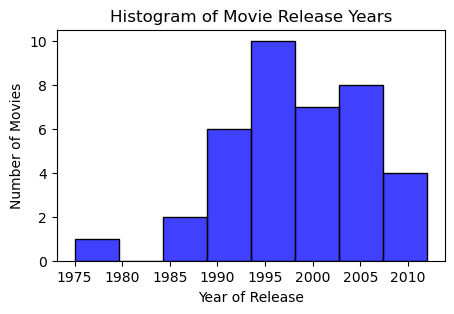

In [192]:
query = """
        MATCH (m:Movie)
        RETURN m.released AS YearRelease
        """

data = graph.run(query).to_data_frame()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(5, 3))
    sns.histplot(data['YearRelease'], kde=False, color='blue')
    plt.title('Histogram of Movie Release Years')
    plt.xlabel('Year of Release')
    plt.ylabel('Number of Movies')
    plt.show()

#### 8 : Who are the 10 actors with the most movie played in

In [194]:
query = """
        MATCH (a:Person)-[:ACTED_IN]->(m:Movie)
        WITH a, count(m) AS movies_count
        ORDER BY movies_count DESC
        LIMIT 10
        RETURN a.name AS Actor, movies_count
        """

results = graph.run(query).to_data_frame()
results

,Actor,movies_count
0,Tom Hanks,12
1,Keanu Reeves,7
2,Meg Ryan,5
3,Jack Nicholson,5
4,Hugo Weaving,5
5,Cuba Gooding Jr.,4
6,Kevin Bacon,3
7,Laurence Fishburne,3
8,Carrie-Anne Moss,3
9,Tom Cruise,3


#### 9 : Delete every movie made by a director of your choosing

In [208]:
query = """
        MATCH (d:Person {name: "Robert Zemeckis"})-[:DIRECTED]->(m:Movie)
        DETACH DELETE m
        """

graph.run(query)

(No data)

#### 10 : Give some statistics that you find interesting.

In [216]:
query = """
        MATCH (p:Person)-[:WROTE]->(m:Movie)
        WHERE p.born IS NOT NULL AND m.released IS NOT NULL
        RETURN avg(m.released - p.born) AS average_writer_age
        """

results = graph.run(query).to_data_frame()
print(f'The average age of writers when their movies are released is {results["average_writer_age"][0]} years old.')

The average age of writers when their movies are released is 45.375 years old.


#### 11 : Sandbox exercise: Who are the actors with the greatest longevity in the industry?

In [403]:
query = """
        MATCH (p:Person)-[:ACTED_IN]->(m:Movie)
        WITH p, MIN(m.released) AS FirstYear, MAX(m.released) AS LastYear
        RETURN p.name AS Actor, LastYear - FirstYear AS `Career Span`
        ORDER BY `Career Span` DESC
        LIMIT 5;
        """

results = graph.run(query).to_data_frame()
results

,Actor,Career Span
0,Jack Nicholson,28
1,Tom Hanks,22
2,Marshall Bell,20
3,Danny DeVito,17
4,Tom Cruise,14


## Real World application 5

You will work on a Twitch dataset found [here](https://www.kaggle.com/andreagarritano/twitch-social-networks). The goal is to learn more about the feat&fun on Twitch. First thing to do is create the network on Neo4j. Insert the node
from Twitch/FR_target and then the edges from Twitch/FR_edges.csv in neo4j. Answer the following using cypher queries

In [478]:
graph = Graph("bolt://localhost:7687", auth=("neo4j", "rootuser"), name="twitch")
target = pd.read_csv(data_dir+'FR_target.csv')
edges = pd.read_csv(data_dir+'FR_edges.csv')

In [163]:
def create_nodes(graph, df):
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Creating nodes"):
        graph.run("CREATE (n:Streamer {id: $id, days: $days, mature: $mature, views: $views, partner: $partner, new_id: $new_id})", 
                  id=row['id'], days=row['days'], mature=row['mature'], views=row['views'], partner=row['partner'], new_id=row['new_id'])

def create_edges(graph, df_edges):
    for index, row in tqdm(df_edges.iterrows(), total=df_edges.shape[0], desc="Creating edges"):
        from_id = int(row['from'])
        to_id = int(row['to'])
        query = """
                MATCH (a:Streamer {new_id: $from_id}), (b:Streamer {new_id: $to_id})
                MERGE (a)-[r1:COLLAB]->(b)
                MERGE (b)-[r2:COLLAB]->(a)
                """
        graph.run(query, from_id=from_id, to_id=to_id)

In [164]:
create_nodes(graph, target)
create_edges(graph, edges)

100%|██████████████████████████████████████████████████████████████████████████| 112666/112666 [26:05<00:00, 71.97it/s]


#### 1 : Give the IDs of the top 10 streamers that have atleast one collaboration.

In [480]:
query = """
        MATCH (s:Streamer)-[:COLLAB]-() 
        RETURN DISTINCT s.new_id AS StreamerID, s.views AS Views
        ORDER BY s.views DESC  
        LIMIT 10
        """

result = graph.run(query).to_data_frame()
result

,StreamerID,Views
0,3459,108432615
1,6420,62713570
2,5511,44534929
3,2161,44374644
4,2799,43059742
5,5968,42801507
6,1751,38404078
7,5804,37754841
8,1552,34295755
9,5844,29998029


#### 2 : Create a density of node degrees. Do you observe a power scale law ? What does it mean ?

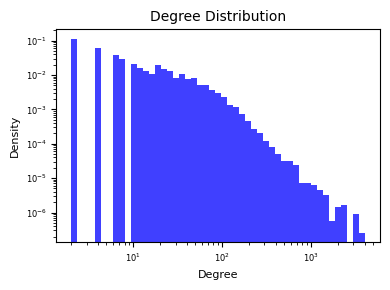

Yes as the log-log relation could be could be considered linear here.
A power law is a functional relationship between two quantities where one quantity varies as a power of another.


In [479]:
query = """
        MATCH (s:Streamer)
        RETURN s.new_id AS StreamerID, size((s)-[:COLLAB]-()) AS Degree
        """
results = graph.run(query).to_data_frame()
degrees = results['Degree'].tolist()
degrees = [x if np.isfinite(x) else np.nan for x in degrees]
degrees = [x for x in degrees if not pd.isna(x)]

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    logbins = np.logspace(np.log10(min(degrees)), np.log10(max(degrees)), 50)
    plt.figure(figsize=(4, 3))
    sns.histplot(degrees, bins=logbins, kde=False, color="blue", stat="density")
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Degree Distribution', fontsize=10)
    plt.xlabel('Degree', fontsize=8)
    plt.ylabel('Density', fontsize=8)
    plt.xticks(fontsize=6)
    plt.yticks(fontsize=6)
    plt.tight_layout()
    plt.show()

print("""Yes as the log-log relation could be could be considered linear here.
A power law is a functional relationship between two quantities where one quantity varies as a power of another.""")

#### 3 : How many streamers has the tag "mature" ?

In [193]:
query = """
        MATCH (s:Streamer {mature: TRUE})
        RETURN count(s) AS mature_tag_count
        """

result = graph.run(query).to_data_frame()
print(f'{result["mature_tag_count"][0]} streamers have the tag "mature".')

2416 streamers have the tag "mature".


#### 4 : Is the collaboration correlated to the "mature" tag ?

In [473]:
query = """
        MATCH (s:Streamer)
        RETURN 
            CASE s.mature WHEN true THEN 1 ELSE 0 END AS Mature,
            size((s)-[:COLLAB]-()) AS Collabs
        """
result = graph.run(query).data()

mature = np.array([r['Mature'] for r in result])
collabs = np.array([r['Collabs'] for r in result])
corr = np.corrcoef(mature, collabs)[0, 1]

print("Correlation coefficient:", round(corr,3), "\n No, the number of collaboration isn't correlated to the 'mature' tag")

Correlation coefficient: 0.033 
 No, the number of collaboration isn't correlated to the 'mature' tag


#### 5 : Do partners collaborate more than non partners ?

In [212]:
query = """
        MATCH (s:Streamer)-[r:COLLAB]->()
        WHERE s.partner IS NOT NULL
        RETURN s.partner as PartnerStatus, avg(size((s)-[:COLLAB]->())) as AvgCollaborations
        """

result = graph.run(query).to_data_frame()
print(f"Yes, avg nb_collab for partners ({result['AvgCollaborations'][1]:.2f}) is significantly higher than avg nb_collab for non-partners ({result['AvgCollaborations'][0]:.2f})")

Yes, avg nb_collab for partners (519.75) is significantly higher than avg nb_collab for non-partners (57.00)


#### 6 : Sandbox exercise: Do partner streamers work more than non-partners ?

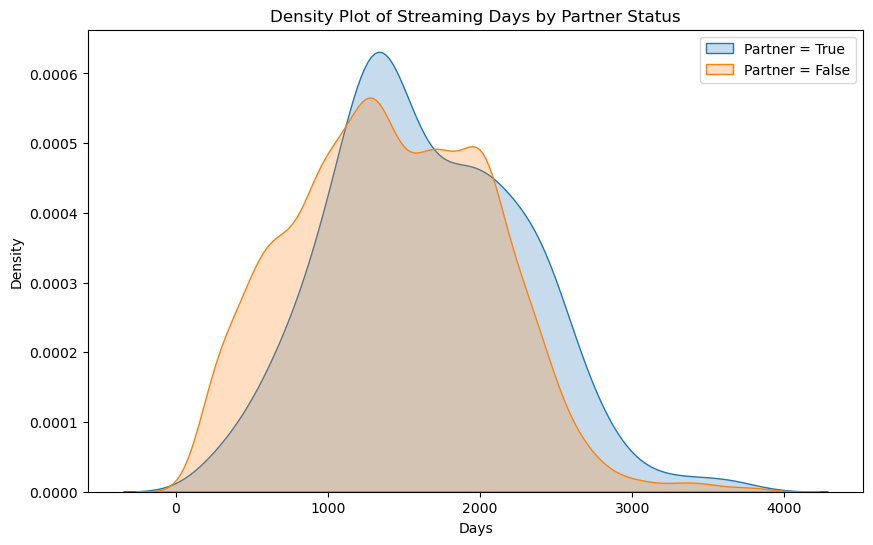

In [475]:
query = """
        MATCH (s:Streamer)
        RETURN s.partner AS PartnerStatus, s.days AS Days
        ORDER BY s.partner, s.days;
        """

data = graph.run(query).to_data_frame()

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(10, 6))
    sns.kdeplot(data=data[data['PartnerStatus'] == True]['Days'], label='Partner = True', fill=True)
    sns.kdeplot(data=data[data['PartnerStatus'] == False]['Days'], label='Partner = False', fill=True)
    plt.title('Density Plot of Streaming Days by Partner Status')
    plt.xlabel('Days')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

## Real World application 6

You will work on a stackoverflow dataset found [here](https://www.kaggle.com/stackoverflow/stack-overflow-tag-network). First thing to do is create the network on Neo4j. You can find the characteristics of the nodes in stack_network_nodes.csv.
Once the node are create you can create the edges between them, you can find them in stack_network_links.csv. The weight of the edge is the column value. Answer the following making use of cypher queries.

In [484]:
graph = Graph("bolt://localhost:7687", auth=("neo4j", "rootuser"), name="stack")
nodes_df = pd.read_csv(data_dir+'stack_network_nodes.csv')
links_df = pd.read_csv(data_dir+'stack_network_links.csv')

def create_nodes(nodes_df):
    for index, row in tqdm(nodes_df.iterrows(), total=nodes_df.shape[0], desc="Creating nodes"):
        node = Node("Keyword", name=row['name'], group=row['group'], nodesize=row['nodesize'])
        graph.merge(node, "Keyword", "name")

def create_relationships(links_df):
    for index, row in tqdm(links_df.iterrows(), total=links_df.shape[0], desc="Creating relationships"):
        source_node = graph.nodes.match("Keyword", name=row['source']).first()
        target_node = graph.nodes.match("Keyword", name=row['target']).first()
        if source_node and target_node:
            rel = Relationship(source_node, "RELATED_TO", target_node, value=row['value'])
            graph.merge(rel)

In [237]:
create_nodes(nodes_df)
create_relationships(links_df)

Creating relationships: 100%|███████████████████████████████████████████████████████| 490/490 [00:03<00:00, 156.29it/s]


#### 1 : What are the 10 most popular keywords ?

In [495]:
query = """
        MATCH (k:Keyword)
        RETURN k.name AS Keyword, k.nodesize AS NodeSize
        ORDER BY k.nodesize DESC
        LIMIT 10
        """

result=graph.run(query).to_data_frame()
result

,Keyword,NodeSize
0,javascript,649.16
1,java,610.65
2,python,438.67
3,php,361.22
4,css,341.17
5,c#,321.13
6,html,272.45
7,c++,268.11
8,android,229.86
9,jquery,208.29


#### 2 : What are the top 10 Co-occurence ?

In [496]:
query = """
        MATCH (k1:Keyword)-[r:RELATED_TO]->(k2:Keyword)
        WITH k1, k2, r.value AS link_weight
        ORDER BY link_weight DESC
        LIMIT 10
        RETURN k1.name AS Keyword1, k2.name AS Keyword2, link_weight
        """

result=graph.run(query).to_data_frame()
result

,Keyword1,Keyword2,link_weight
0,html,css,126.571127
1,css,html,126.571127
2,hibernate,spring,103.268284
3,spring,hibernate,103.268284
4,ruby-on-rails,ruby,95.361311
5,ruby,ruby-on-rails,95.361311
6,ios,swift,87.219642
7,swift,ios,87.219642
8,html5,css,87.138270
9,css,html5,87.138270


#### 3 : How many keywords are in group 1 ?

In [497]:
query = """
        MATCH (k:Keyword)
        WHERE k.group = 1
        RETURN count(k) AS kw_grp1
        """

result=graph.run(query).to_data_frame()
print("There are", result['kw_grp1'][0], "keywords in group 1")

There are 10 keywords in group 1


#### 4 : Is the Co-occurence correlated to the "group" of the keyword ?  

In [498]:
query = """
        MATCH (k:Keyword)-[r:RELATED_TO]->(k2:Keyword)
        WHERE k.group = k2.group
        RETURN k.group AS Group, AVG(r.value) AS `Co-occurence average`
        ORDER BY `Co-occurence average` DESC;
        """

result = graph.run(query).to_data_frame()
print("The Co-occurence doesn't seem to be independant from the group of the keywords.")
result

The Co-occurence doesn't seem to be independant from the group of the keywords.


,Group,Co-occurence average
0,14,49.794068
1,4,49.134879
2,10,38.750501
3,3,38.502860
4,12,37.146590
5,8,36.944779
6,6,35.697403
7,7,34.958232
8,1,33.800162
9,11,33.685943


#### 5 : Sandbox exercise: To which keywords is 'python' the most related ?

In [499]:
query = """
        MATCH (k:Keyword {name: 'python'})-[r:RELATED_TO]->(related:Keyword)
        RETURN related.name AS RelatedKeyword, r.value AS RelationshipValue
        ORDER BY r.value DESC
        LIMIT 3;
        """

result = graph.run(query).to_data_frame()
result

,RelatedKeyword,RelationshipValue
0,django,49.905943
1,machine-learning,30.270774
2,r,28.535748
